# Regularización


En este curso sobre *deep learning*, hemos visto que las redes neuronales son muy eficaces para resolver diversos problemas. Sin embargo, ciertos problemas importantes limitan su potencial. Hoy hablaremos del *overfitting* (sobreajuste).

El *overfitting* ocurre cuando el modelo se adapta demasiado a los datos de entrenamiento, capturando incluso anomalías y ruido. Como resultado, su rendimiento en los datos de prueba es deficiente.

![Overfitting](./images/overfitting.png)

Este problema es común durante el entrenamiento de redes neuronales. Para monitorearlo, se utiliza un conjunto de datos de validación que se evalúa periódicamente para verificar que la función de pérdida (*loss*) disminuya correctamente. En caso de *overfitting*, las curvas de *loss* de entrenamiento y validación se ven así:

![Overfitting Curve](./images/overfittingcurve.png)

La pérdida de entrenamiento sigue disminuyendo, mientras que la pérdida de validación aumenta. Esto indica que el modelo está aprendiendo las particularidades de los datos de entrenamiento, lo cual es lo contrario a lo que deseamos.

Al reflexionar sobre esto, tiene lógica: el modelo intenta minimizar la pérdida en los datos de entrenamiento.

Este es un aspecto crucial a considerar durante el entrenamiento de una red neuronal. Para combatir este problema, existen varias técnicas. Aquí presentaremos dos, intentando entender por qué funcionan.

Estas dos técnicas son la **regularización L2** y el ***dropout***. Este cuaderno se inspira en el [curso de fastai](https://github.com/fastai/fastbook/tree/master).


## Regularización L2


La regularización L2 es una técnica sencilla. Consiste en añadir la suma de los pesos al cuadrado a la función de pérdida (*loss*), utilizando un factor $wd$ llamado *weight_decay* (decaimiento de pesos). Este término en la función de pérdida empuja a los pesos a ser lo más pequeños posible.


### ¿Por qué reduce el *overfitting*?


Intuitivamente, pesos más grandes pueden crear pendientes más pronunciadas en la función de pérdida (*loss*).

Para confirmar esta intuición, observemos qué ocurre con la función parabólica:
$y = a \times x^2$


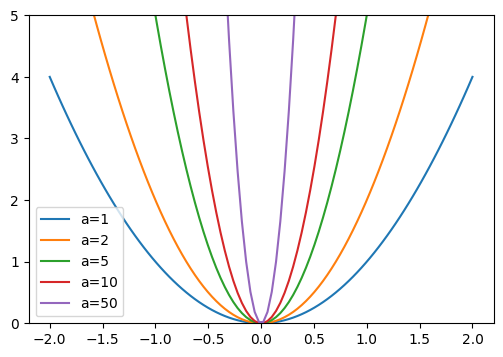

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(6,4))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Cuanto mayor sea $a$, más pronunciada se vuelve la parábola. Si comparamos $a$ con nuestros pesos, podemos imaginar que pesos grandes conducen a una función representada por una red con cambios abruptos, lo cual puede corresponder a *overfitting*.

Esta justificación puede parecer un poco "mágica", pero en la práctica, la regularización L2 tiene un impacto positivo real para prevenir el *overfitting*.

Limitar el valor de los pesos también reduce la capacidad de aprendizaje de la red. Sin embargo, esta limitación permite una mejor generalización y evita el *overfitting*.


### Implementación del método


Para implementar la regularización L2, se puede hacer manualmente añadiendo el término a nuestra función de pérdida:
$L(w) = L_0(w) + wd \sum_{i=1}^{n} w_i^2$, donde $L(w)$ es la pérdida regularizada, $L_0(w)$ es la función de pérdida clásica, $wd$ (*weight_decay*) es el coeficiente de regularización y $w_i$ es un peso del modelo.
O en Python: ```loss_regu = loss + wd * (parameters**2).sum()```.

Más simplemente, se puede utilizar la regularización L2 en PyTorch añadiendo el parámetro *weight_decay* en la inicialización del optimizador (por defecto es 0). Por ejemplo:


In [ ]:
import torch
params=torch.tensor([1.0], requires_grad=True)
# Pour SGD
torch.nn.optim.SGD(params, lr=0.1, weight_decay=0.1)
# Pour Adam
torch.nn.optim.Adam(params, lr=0.1, weight_decay=0.1)

Si tu modelo tiene problemas de *overfitting*, ¡esta es una técnica que debes probar!


## *Dropout*


El *dropout* es un método de regularización introducido en el artículo [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580). La idea es sencilla: en cada paso del entrenamiento, se ponen aleatoriamente a cero una parte de las activaciones de la red. De esta manera, cada neurona se vuelve necesaria para producir una salida (*output*) coherente a partir de la entrada (*input*).

![Dropout](./images/dropout.png)


### Intuición


Para entender el *dropout*, podemos usar una metáfora del autor del artículo (Geoffrey Hinton):

*"Fui a mi banco. Los cajeros cambiaban constantemente y le pregunté a uno de ellos por qué. Me dijo que no lo sabía, pero que a menudo los movían de lugar. Pensé que debía ser porque se requeriría cooperación entre los empleados para cometer un fraude bancario, y que esto limitaría enormemente las posibilidades de hacerlo. Esto me hizo darme cuenta de que eliminar aleatoriamente un subconjunto diferente de neuronas en cada ejemplo evitaría las 'conspiraciones' y, por lo tanto, reduciría el sobreajuste."*

Esto evita que las neuronas "hagan trampa", es decir, que encuentren un atajo fraudulento para hacer una predicción (podríamos suponer que cada neurona se basa en un detalle de la entrada únicamente para hacer su predicción).

Este método obliga a las neuronas a cooperar e incrementa el ruido en las activaciones, lo que conduce a un modelo más robusto. También podemos ver el *dropout* como una mezcla de muchos pequeños modelos que cooperan durante la fase de prueba.


### Implementación


Podemos implementar el *dropout* de la siguiente manera en Python:


In [4]:
import torch.nn as nn
class Dropout(nn.Module):
  def __init__(self, p): 
    self.p = p
  def forward(self, x):
    # Le droupout n'est appliqué que pendant l'entrainement
    if not self.training: 
      return x
    # On crée un masque de dropout à partir d'une distribution de Bernoulli
    mask = torch.zeros_like(x)
    mask.bernoulli_(1 - self.p) # chaque élément a une probabilité de 1-p d'être mis à 0 sinon il est mis à 1
    # On applique le masque et on divise par 1-p pour garder une moyenne cohérente
    return x * mask/(1-self.p)

La capa también está implementada en PyTorch y se puede utilizar con [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), que toma como parámetro $p$ la probabilidad de que una activación se ponga a cero.

**Nota**: Al utilizar *dropout* en PyTorch, es importante asegurarse de cambiar el modelo al modo entrenamiento (*train*) durante el entrenamiento y al modo evaluación (*eval*) durante la validación/prueba (al igual que con la *batchnorm*). Esto se puede hacer con ```model.train()``` y ```model.eval()```.
